<h1 style = "font-size:3rem;color:darkcyan"> MFCC - Mel Frequency Cepstrum Coefficient</h1>

MFCC are often used for speaker/speech recognition. 

The timbre of speech is dependend on how it is filtered by the shape of the vocal tract (lips, tongue, nosal cavity, etc.). This shape is related to the envelope of the short time power spectrum, which can be represented by the mel frequency cepstrum coefficient (MFCC)

<h3 style = "font-size:3rem;color:darkcyan">Mel-frequency</h3>
Short time fourier transform, or spectrogram, does not quite represent audio features as humans perceive them as.
Ideally we want to have audio features in which only the relevant information of both frequency and amplitude is presented. Meaning both frequnecy and amplitude should be represented logarithmically.

We can transform frequency in such a way that each step has the same perceptual distance by transforming it to Mel-frequency. 
calculation: $m = 2595 \cdot log(1 + \frac{f}{700})$

Converting spectrogram to Mel-scale: 
- Choose number of Mel bands
- Compute Mel filter banks
- Apply filter bands to spectrogram

Text(0.5, 1.0, 'Zoomed In')

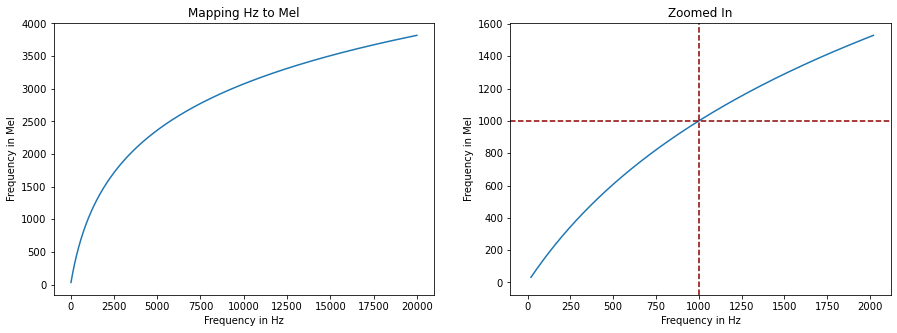

In [108]:
# Mapping:
f = np.arange(20,20000) # 20Hz to 20kHz
m = 2595 * np.log10(1 + f / 700)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(f,m)
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Mapping Hz to Mel')

plt.subplot(1,2,2)
plt.plot(f[:2000],m[:2000]) # zoomed in
plt.axline((1000,0),(1000,1000), linestyle ='--', color='darkred')
plt.axline((0,1000),(1000,1000), linestyle ='--', color='darkred')
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Zoomed In')

In [ ]:
# converting spectrogram to mel scale
# choose number of mel bands

<h3 style = "font-size:3rem;color:darkcyan">Cepstrum</h3>
Speech can be seen as a combination of two processes: 

1. Larynx creating a pulse train, controling the pitch of your voice
2. Vocal tract (tongue, lips, cavities) that filters the sound

In the time signal these are convolved, so they both show up as the same spike in the frequency-domain when performing the fourier transform. For speeker identification you want to seperate these the vocal tract, as this information is more important for speech recognition. Cepstrum essentially differentiates the vocal tract from the larynx. Larynx will have a higher rate of change, or quefrency, as it changes faster than the vocal tract, that will have low quefrency. 

Cepstrum can be seen as the rate of change in spectral bands that is created by: 

1. Perform DFT on the time signal
2. Perform a transformation to seperate the larynx from the vocal tract. This is done by taking the log of the magnitude
3. Perform the inverse DFT to get the cepstrum


In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.feature


In [75]:
# import audio file
signal , sample_rate = librosa.load('samples/Violin.wav')
signal = signal[10000:101024]

#win_size = 1024
#signal = signal[10000:10000+win_size]
N = len(signal)


# take snippet

# take DFT of fragment

DFT = np.fft.fft(signal)

DFT_log_pow = np.log10(abs(DFT))

C = np.fft.ifft(DFT_log_pow)

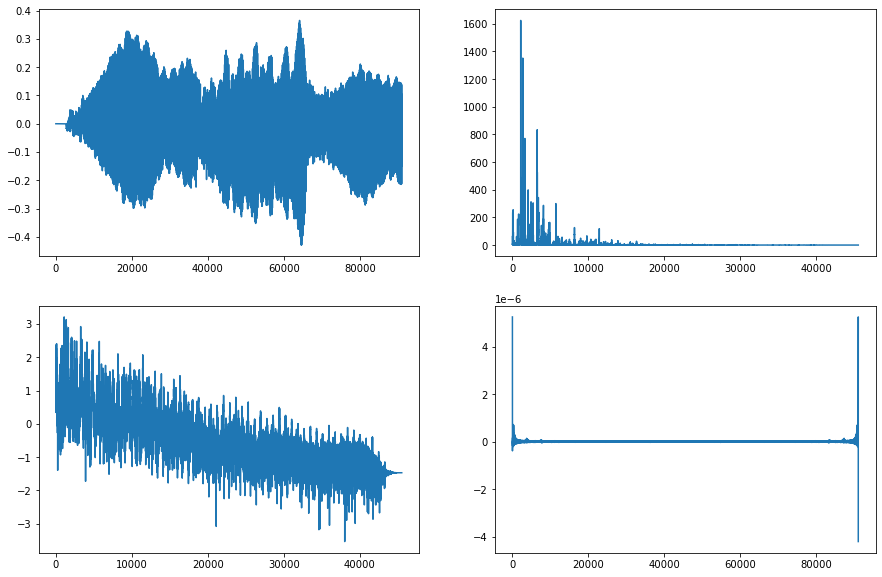

In [78]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.plot(signal)

plt.subplot(2,2,2)
plt.plot(abs(DFT[:int(np.round(N / 2) - 1)]))

plt.subplot(2,2,3)
plt.plot(DFT_log_pow[:int(np.round(N / 2) - 1)])

plt.subplot(2,2,4)
plt.plot(np.real(C[::-1] / N))


In [69]:
signal = signal[10000:101024]

N = len(signal)
print(N)
DFT = np.fft.fft(signal)

iDFT = np.fft.fft(DFT)

71024


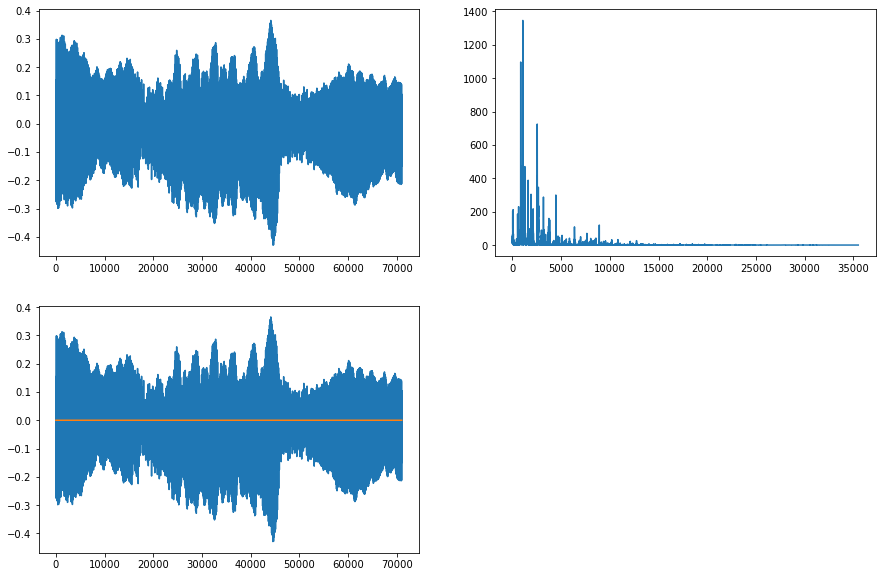

In [70]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(signal)

plt.subplot(2,2,2)

plt.plot(abs(DFT[:int(np.round(N / 2) - 1)]))

plt.subplot(2,2,3)
plt.plot(np.real(iDFT[::-1]) / N)
plt.plot(np.imag(iDFT))